In [1]:
import sys
import os
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay,
)

import matplotlib.pyplot as plt

# Ensure project root on path (in case you want to use pipeline modules later)
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

processed_path = Path("../data/processed/warranty_claims_processed.csv")
df = pd.read_csv(processed_path, parse_dates=["Claim_Date",
                                              "Vehicle_Registration_Date",
                                              "Vehicle_Failure_Date"])
df.head()


Matplotlib is building the font cache; this may take a moment.


,Claim_ID,Claim_Date,Vehicle_Registration_Date,Vehicle_Failure_Date,Vehicle_MFD_Year,Vehicle_Age_Years,Days_Failure_to_Claim,Mileage_km,Part_Group,Subpart_Code,Failure_Mode,Customer_Type,Region,Labor_Cost,Material_Cost,Total_Cost,Burden_Ratio,Final_Claim_Decision,Final_DPR_Decision
0,CLM_000001,2022-04-08,2020-06-04,2022-03-19,2020,1.842574,20,27512.065570,Chassis,CHS_A,No_Start,Retail,Region_2,154.603156,388.187881,542.791037,0.382099,Approve,Reject
1,CLM_000002,2024-04-27,2023-10-12,2024-04-14,2023,0.542094,13,4840.819371,Body,BODY_B,No_Start,Retail,Region_3,142.265157,68.022091,210.287249,0.791511,Approve,Reject
2,CLM_000003,2023-12-18,2018-09-16,2023-11-17,2018,5.253936,31,74398.919284,Electronics,ELEC_A,Leak,Retail,Region_2,159.957023,426.241409,586.198432,0.362170,Reject,Reject
3,CLM_000004,2023-04-26,2017-08-15,2023-03-17,2017,5.694730,40,58781.129706,Body,BODY_A,Electrical_Issue,Retail,Region_3,278.097472,168.986598,447.084071,0.621667,Approve,Approve
4,CLM_000005,2023-04-20,2016-11-22,2023-04-04,2016,6.406571,16,87272.268653,Electronics,ELEC_C,No_Start,Retail,Region_2,226.480249,334.526356,561.006604,0.734220,Reject,Reject


In [2]:
TARGET_COL = "Final_Claim_Decision"

# Drop ID + dates from features; keep engineered numeric and categoricals
feature_cols = [
    "Vehicle_MFD_Year",
    "Vehicle_Age_Years",
    "Days_Failure_to_Claim",
    "Mileage_km",
    "Labor_Cost",
    "Material_Cost",
    "Total_Cost",
    "Burden_Ratio",
    "Part_Group",
    "Subpart_Code",
    "Failure_Mode",
    "Customer_Type",
    "Region",
]

X = df[feature_cols].copy()
y = df[TARGET_COL].copy()

X.head(), y.value_counts()


(   Vehicle_MFD_Year  Vehicle_Age_Years  Days_Failure_to_Claim    Mileage_km  \
 0              2020           1.842574                     20  27512.065570   
 1              2023           0.542094                     13   4840.819371   
 2              2018           5.253936                     31  74398.919284   
 3              2017           5.694730                     40  58781.129706   
 4              2016           6.406571                     16  87272.268653   
 
    Labor_Cost  Material_Cost  Total_Cost  Burden_Ratio   Part_Group  \
 0  154.603156     388.187881  542.791037      0.382099      Chassis   
 1  142.265157      68.022091  210.287249      0.791511         Body   
 2  159.957023     426.241409  586.198432      0.362170  Electronics   
 3  278.097472     168.986598  447.084071      0.621667         Body   
 4  226.480249     334.526356  561.006604      0.734220  Electronics   
 
   Subpart_Code      Failure_Mode Customer_Type    Region  
 0        CHS_A         

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((3750, 13), (1250, 13))

In [4]:
numeric_features = [
    "Vehicle_MFD_Year",
    "Vehicle_Age_Years",
    "Days_Failure_to_Claim",
    "Mileage_km",
    "Labor_Cost",
    "Material_Cost",
    "Total_Cost",
    "Burden_Ratio",
]

categorical_features = [
    "Part_Group",
    "Subpart_Code",
    "Failure_Mode",
    "Customer_Type",
    "Region",
]

numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
)

model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("classifier", clf),
    ]
)
model


,steps,"[('preprocess', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [5]:
model.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [6]:
y_pred = model.predict(X_test)

print("Classification report:")
print(classification_report(y_test, y_pred))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

# Get predicted probabilities for positive class ("Approve")
class_index = list(model.classes_).index("Approve")
y_proba = model.predict_proba(X_test)[:, class_index]

roc_auc = roc_auc_score((y_test == "Approve").astype(int), y_proba)
print(f"ROC AUC (Approve vs Reject): {roc_auc:.3f}")



Classification report:
              precision    recall  f1-score   support

     Approve       0.60      0.56      0.58       573
      Reject       0.65      0.68      0.66       677

    accuracy                           0.62      1250
   macro avg       0.62      0.62      0.62      1250
weighted avg       0.62      0.62      0.62      1250

Confusion matrix:
[[323 250]
 [219 458]]
ROC AUC (Approve vs Reject): 0.667


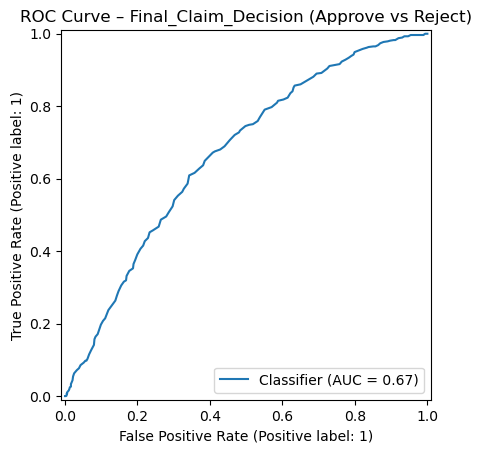

In [7]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    (y_test == "Approve").astype(int),
    y_proba,
    ax=ax,
)
ax.set_title("ROC Curve – Final_Claim_Decision (Approve vs Reject)")
plt.show()


In [8]:
scored_dir = Path("../data/processed")
scored_dir.mkdir(parents=True, exist_ok=True)

X_test_copy = X_test.copy()
X_test_copy["Final_Claim_Decision_True"] = y_test.values
X_test_copy["Final_Claim_Decision_Pred"] = y_pred
X_test_copy["Prob_Approve"] = y_proba

scored_path = scored_dir / "warranty_claims_scored.csv"
X_test_copy.to_csv(scored_path, index=False)

scored_path


WindowsPath('../data/processed/warranty_claims_scored.csv')